In [ ]:
%run D:\codes\arome\read_in_arome-kufstein.ipynb
%run D:\codes\confg

In [1]:
%%capture
"""Compare different models (ICON, AROME, UKMO, WRF_ACINN) with radiosonde, in one plot with pressure as y-variable"""
import warnings

import xarray as xr

import metpy
import metpy.calc as mpcalc
import numpy as np
import pandas as pd
import wrf
from matplotlib import pyplot as plt
from metpy.plots import SkewT
from metpy.units import units
from netCDF4 import Dataset
import sys
np.set_printoptions(threshold=sys.maxsize)

    
warnings.filterwarnings("ignore")

In [2]:
# Specify the launch date and time
launch_date = pd.to_datetime('2017-10-16 02:15:05',
                             format='%Y-%m-%d %H:%M:%S')

time_for_model = pd.to_datetime('2017-10-16 03:00:00',
                                format='%Y-%m-%d %H:%M:%S')  # TODO can change here the time

In [3]:
def read_in_arome(time, method, lon, lat):
    """plot the MODEL output of AROME as it would be a Radiosonde"""
    my_variable_list = ["p", "q", "th", "u", "v", "z"]

    if (method == "sel") | (method == "interp"):
        print(f"Your selected method is {method}")
    else:
        raise AttributeError(
            "You have to define a method (sel or interp) how the point near the LOWI should be selected")

    df_final = read_3D_variables_AROME(variables=my_variable_list, method=method, lon=lon, lat=lat, time=time)

    # print(df_final["p"].metpy.unit_array.magnitude) Extract values

    df_final["windspeed"] = metpy.calc.wind_speed(df_final["u"], df_final["v"])
    df_final["wind direction"] = metpy.calc.wind_direction(df_final["u"], df_final["v"], convention='from')
    df_final["temperature"] = metpy.calc.temperature_from_potential_temperature(df_final["p"], df_final["th"])
    df_final["dewpoint"] = metpy.calc.dewpoint_from_specific_humidity(pressure=df_final["p"],
                                                                      temperature=df_final["temperature"],
                                                                      specific_humidity=df_final["q"])

    p = df_final["p"].metpy.unit_array.to(units.hPa)  # Metadata is removed
    T = df_final["temperature"].metpy.unit_array.to(units.degC)

    Td = df_final["dewpoint"].metpy.unit_array
    wind_speed = df_final["windspeed"].metpy.unit_array.to(units.knots)
    wind_dir = df_final['wind direction']
    u, v = mpcalc.wind_components(wind_speed, wind_dir)

    ds = xr.Dataset()

    # Add variables to the dataset
    ds['u_wind'] = xr.DataArray(u.magnitude, dims=('height',),
                                coords={'height': df_final["z"].values},
                                attrs={'units': str(u.units)})
    ds['v_wind'] = xr.DataArray(v.magnitude, dims=('height',),
                                coords={'height': df_final["z"].values},
                                attrs={'units': str(v.units)})
    ds['pressure'] = xr.DataArray(p.magnitude, dims=('height',),
                                  coords={'height': df_final["z"].values},
                                  attrs={'units': str(p.units)})
    ds['temperature'] = xr.DataArray(T.magnitude, dims=('height',),
                                     coords={'height': df_final["z"].values},
                                     attrs={'units': str(T.units)})
    ds['dewpoint'] = xr.DataArray(Td.magnitude, dims=('height',),
                                  coords={'height': df_final["z"].values},
                                  attrs={'units': str(Td.units)})

    return ds.metpy.quantify()

Your selected method is sel


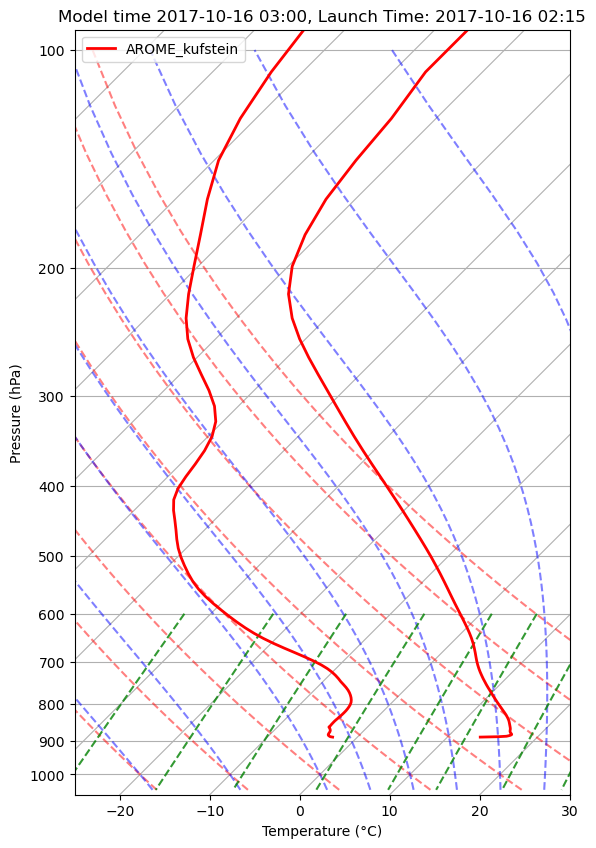

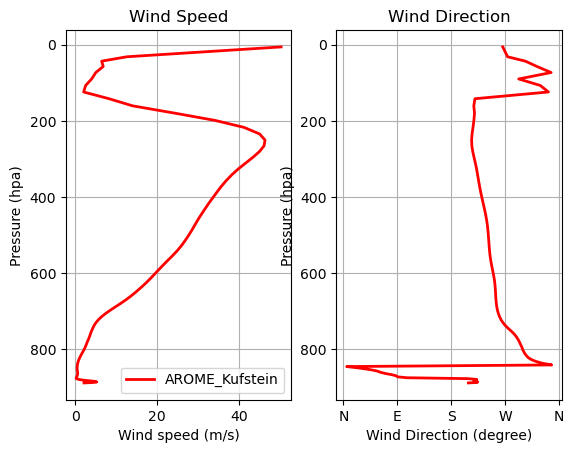

In [5]:

df_arome_kufstein = read_in_arome(time=30, method='sel', lon=11, lat=47)
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=45, rect=(0.1, 0.1, 0.55, 0.85))


skew.plot(df_arome_kufstein["pressure"].values, df_arome_kufstein["temperature"].values, color=colordict["AROME"], label="AROME_kufstein", linewidth=2)
skew.plot(df_arome_kufstein["pressure"].values, df_arome_kufstein["dewpoint"].values, color=colordict["AROME"], linewidth=2)

skew.ax.set_adjustable('datalim')

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

plt.title(
    f"Model time {pd.to_datetime(time_for_model).strftime('%Y-%m-%d %H:%M')}, Launch Time: {pd.to_datetime(launch_date).strftime('%Y-%m-%d %H:%M')}")

skew.ax.set_xlabel('Temperature (°C)')
skew.ax.set_ylabel('Pressure (hPa)')
skew.ax.set_xlim(-25, 30)
skew.ax.set_ylim(1000, 100)

plt.legend()

plt.savefig("D:/plots/arome_kufstein.png")


plt.legend()

fig, axarr = plt.subplots(nrows=1, ncols=2)
axlist = axarr.flatten()

ff_arome = mpcalc.wind_speed(df_arome_kufstein["u_wind"], df_arome_kufstein["v_wind"])
dd_arome = mpcalc.wind_direction(df_arome_kufstein["u_wind"], df_arome_kufstein["v_wind"])

axlist[0].plot(ff_arome, df_arome_kufstein['pressure'], label="AROME_Kufstein", color=colordict["AROME"], linewidth=2)

axlist[0].invert_yaxis()
# ax.set_yscale('log')
axlist[0].set_ylabel("Pressure (hpa)")
axlist[0].set_xlabel("Wind speed (m/s)")
axlist[0].set_title("Wind Speed")
axlist[0].legend()
axlist[0].grid(True)

axlist[1].plot(dd_arome, df_arome_kufstein['pressure'], label="AROME_Kufstein", color=colordict["AROME"], linewidth=2)
axlist[1].invert_yaxis()
# ax.set_yscale('log')
axlist[1].set_ylabel("Pressure (hpa)")
axlist[1].set_xlabel("Wind Direction (degree)")
axlist[1].set_title("Wind Direction")
axlist[1].grid(True)
xticks = np.arange(0, 361, 90)
xtick_labels = ['N', 'E', 'S', 'W', 'N']
axlist[1].set_xticks(xticks)
axlist[1].set_xticklabels(xtick_labels)

plt.savefig("D:/plots/arome_wind_Kufstein.png")